In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pip install numpy pandas matplotlib yfinance scipy

Note: you may need to restart the kernel to use updated packages.


[*********************100%***********************]  1 of 1 completed
C:\Users\Juswanth-T\AppData\Local\Temp\ipykernel_10824\723132537.py:16: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_result = signal.cwt(close_prices, signal.ricker, widths)


(1509,)


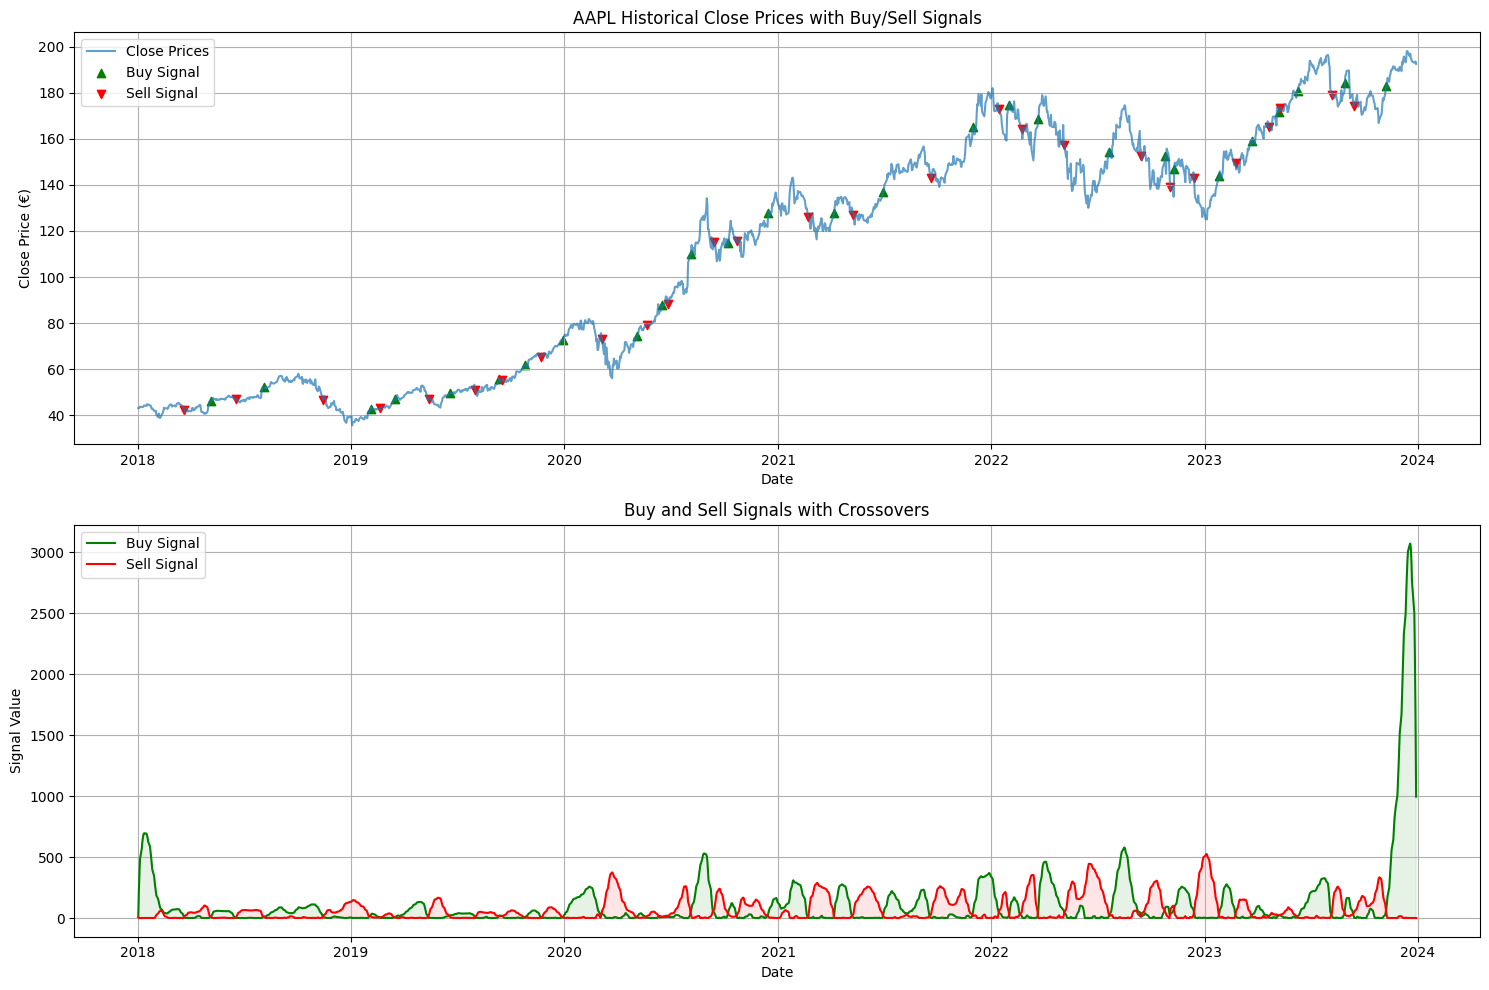

In [2]:

import yfinance as yf
from scipy import signal

# Download historical stock data
# In class we have analysed for Siemens AG (SIE.DE) stock data. You can change the ticker to any other stock you want to analyse.
# Now we are considering Apple Inc. (AAPL) stock data. 
ticker = "AAPL" 
stock_data = yf.download(ticker, start="2018-01-01", end="2023-12-30")
close_prices = stock_data['Close'].values
close_prices = close_prices.reshape(-1)

print(close_prices.shape)

# Compute the Continuous Wavelet Transform (CWT) using the Ricker wavelet
widths = np.arange(1, 15)
cwt_result = signal.cwt(close_prices, signal.ricker, widths)

# Extract the relevant CWT coefficients for analysis
cwt_positive = np.where(cwt_result > 0, cwt_result, 0)
cwt_negative = np.where(cwt_result < 0, cwt_result, 0)

# Save CWT coefficients to files
np.savetxt("cwt_positive.csv", cwt_positive, delimiter=",")
np.savetxt("cwt_negative.csv", cwt_negative, delimiter=",")

# Calculate the buy and sell signals from the CWT coefficients
buy_signal = pd.Series(np.sum(cwt_positive, axis=0), index=stock_data.index)
sell_signal = pd.Series(-np.sum(cwt_negative, axis=0), index=stock_data.index)

# Identify buy and sell signal crossovers
cross_above = (buy_signal >= sell_signal) & (buy_signal.shift(1) < sell_signal.shift(1))
cross_below = (buy_signal <= sell_signal) & (buy_signal.shift(1) > sell_signal.shift(1))

# Plot the stock prices, buy/sell signals, and the buy and sell signals for crossovers
plt.figure(figsize=(15, 10))

# Plot Close Prices with Buy/Sell Signals
plt.subplot(2, 1, 1)
plt.plot(stock_data.index, stock_data['Close'], label='Close Prices', alpha=0.7)
plt.scatter(stock_data.index[cross_above], stock_data['Close'][cross_above],
            label='Buy Signal', marker='^', color='g')
plt.scatter(stock_data.index[cross_below], stock_data['Close'][cross_below],
            label='Sell Signal', marker='v', color='r')
plt.title(f'{ticker} Historical Close Prices with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Close Price (€)')
plt.legend()
plt.grid(True)

# Plot Buy and Sell Signals Over Time
plt.subplot(2, 1, 2)
plt.plot(stock_data.index, buy_signal, label='Buy Signal', color='g')
plt.plot(stock_data.index, sell_signal, label='Sell Signal', color='r')
plt.fill_between(stock_data.index, buy_signal, sell_signal,
                 where=(buy_signal >= sell_signal), interpolate=True,
                 color='green', alpha=0.1)
plt.fill_between(stock_data.index, buy_signal, sell_signal,
                 where=(buy_signal <= sell_signal), interpolate=True,
                 color='red', alpha=0.1)
plt.title('Buy and Sell Signals with Crossovers')
plt.xlabel('Date')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)




plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed
C:\Users\Juswanth-T\AppData\Local\Temp\ipykernel_10824\756276669.py:52: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_result = signal.cwt(close_prices, signal.ricker, widths_list)


Best widths: 29
Best threshold: 0.1
Best performance: 161.3990258013355%
Return: 61.39902580133552%


C:\Users\Juswanth-T\AppData\Local\Temp\ipykernel_10824\756276669.py:83: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  cwt_result = signal.cwt(close_prices, signal.ricker, best_widths)


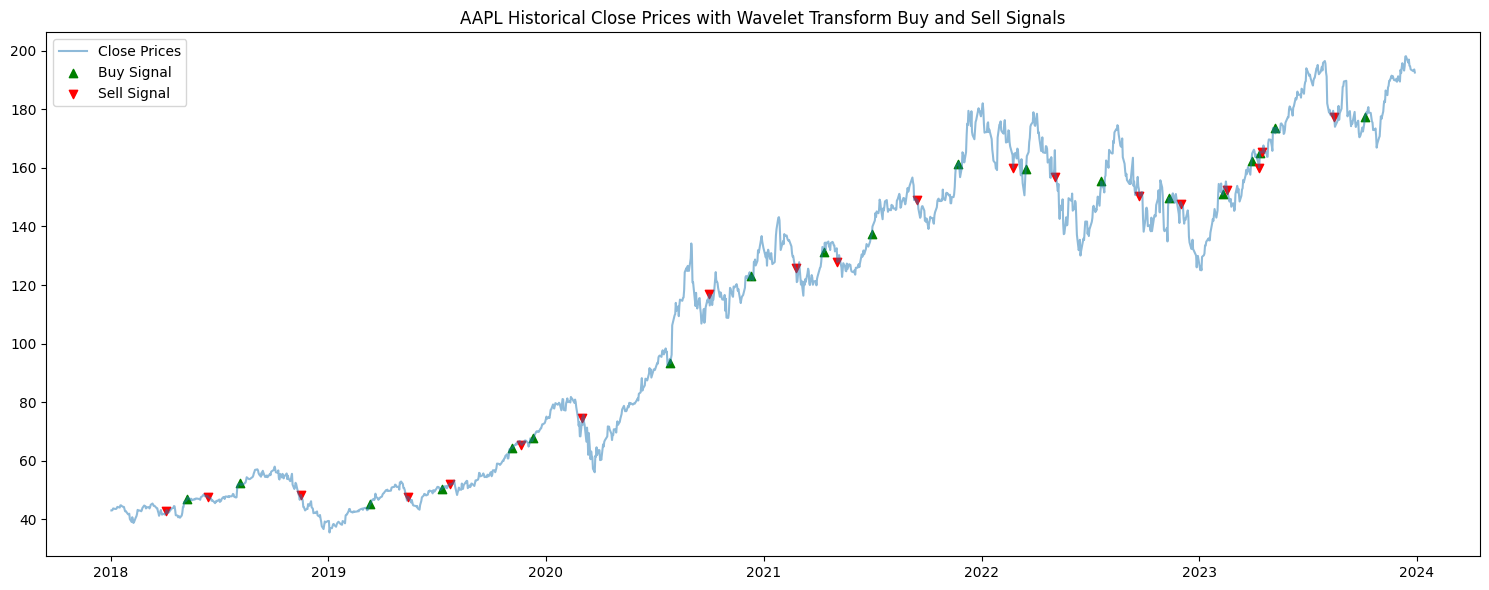

In [3]:

# Download historical stock data
# In class we have analysed for Siemens AG (SIE.DE) stock data. You can change the ticker to any other stock you want to analyse.
# Now we are considering Apple Inc. (AAPL) stock data.
ticker = "AAPL"
stock_data = yf.download(ticker, start="2018-01-01", end="2023-12-30")

# Define parameter ranges
widths_range = np.arange(1, 30)
threshold_range = np.arange(0.1, 1.0, 0.1)

# Store the best parameters and their performance
best_widths = None
best_threshold = None
best_performance = -np.inf

def backtest(stock_data, cross_above, cross_below):
    # We'll start with one "unit" of cash
    cash = 1.0  
    stock = 0.0  
    position = "out"  

    # Go through each day in our data
    for i in range(len(stock_data)):
        # If we have a buy signal and we're not already holding the stock
        if cross_above.iloc[i] and position == "out":
            # Buy the stock
            stock += cash / stock_data['Close'].iloc[i]
            cash = 0.0
            position = "in"
        # If we have a sell signal and we're holding the stock
        elif cross_below.iloc[i] and position == "in":
            # Sell the stock
            cash += stock * stock_data['Close'].iloc[i]
            stock = 0.0
            position = "out"

    # Return our final portfolio value
    if position == "in":
        return cash + stock * stock_data['Close'].iloc[-1]
    else:
        return cash

cnt = 0
# Go through each combination of parameters
close_prices = stock_data['Close'].values
close_prices = close_prices.reshape(-1)
widths_list = []
for widths in widths_range:
    widths_list.append(widths)
    for threshold in threshold_range:
        # Compute the CWT
        cwt_result = signal.cwt(close_prices, signal.ricker, widths_list)

        # Extract relevant coefficients
        cwt_positive = np.where(cwt_result > threshold, cwt_result, 0)
        cwt_negative = np.where(cwt_result < -threshold, cwt_result, 0)

    
        # Calculate buy / sell signals
        buy_signal = pd.Series(np.sum(cwt_positive, axis=0), index=stock_data.index)
        sell_signal = pd.Series(-np.sum(cwt_negative, axis=0), index=stock_data.index)
        cross_above = (buy_signal >= sell_signal) & (buy_signal.shift(1) < sell_signal.shift(1))
        cross_below = (buy_signal <= sell_signal) & (buy_signal.shift(1) > sell_signal.shift(1))

        # Calculate performance based on trading signals
        performance = backtest(stock_data, cross_above, cross_below)
        performance_value = performance.iloc[-1] if isinstance(performance, pd.Series) else performance

        # Update best parameters if this performance is better
        if performance_value > best_performance:
            best_performance = performance_value
            best_widths = widths
            best_threshold = threshold

# Print the best parameters
print(f"Best widths: {best_widths}")
print(f"Best threshold: {best_threshold}")
print(f"Best performance: {best_performance * 100}%")
print(f"Return: {(best_performance - 1) * 100}%")

# Recalculate the CWT and buy/sell signals using the best parameters
best_widths = np.arange(1, best_widths)
cwt_result = signal.cwt(close_prices, signal.ricker, best_widths)
cwt_positive = np.where(cwt_result > best_threshold, cwt_result, 0)
cwt_negative = np.where(cwt_result < -best_threshold, cwt_result, 0)
buy_signal = pd.Series(np.sum(cwt_positive, axis=0), index=stock_data.index)
sell_signal = pd.Series(-np.sum(cwt_negative, axis=0), index=stock_data.index)
cross_above = (buy_signal >= sell_signal) & (buy_signal.shift(1) < sell_signal.shift(1))
cross_below = (buy_signal <= sell_signal) & (buy_signal.shift(1) > sell_signal.shift(1))

# Plot the stock prices and buy/sell signals
plt.figure(figsize=(15, 6))
plt.plot(stock_data.index, stock_data['Close'], label='Close Prices', alpha=0.5)
plt.scatter(stock_data.index[cross_above], stock_data['Close'][cross_above], label='Buy Signal', marker='^', color='g')
plt.scatter(stock_data.index[cross_below], stock_data['Close'][cross_below], label='Sell Signal', marker='v', color='r')
plt.title(f'{ticker} Historical Close Prices with Wavelet Transform Buy and Sell Signals')
plt.legend()
plt.tight_layout()
plt.show()